In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
cal_fire_data = pd.read_csv("../data/cal_fire_data_cleaned.csv")
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

In [3]:
cal_fire_data = pd.get_dummies(cal_fire_data, columns=cal_fire_data.select_dtypes('object').columns)
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 59 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Assessed Improved Value (parcel)                                    42789 non-null  float64
 1   Latitude                                                            42789 non-null  float64
 2   Longitude                                                           42789 non-null  float64
 3   Age                                                                 42789 non-null  float64
 4   Destroyed                                                           42789 non-null  int64  
 5   * Structure Type_Church                                             42789 non-null  bool   
 6   * Structure Type_Commercial Building Multi Story                    42789 non-null  bool   
 7   * Structure T

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = cal_fire_data.drop(columns='Destroyed')
y = cal_fire_data.Destroyed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=216, stratify=cal_fire_data['Destroyed'])

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'min_samples_split': [2, 4, 6, 8, 10, 12],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': range(1, 8)
}


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report


In [6]:
gbc = GradientBoostingClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)

grid_search = GridSearchCV(gbc, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best_params:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 7560 candidates, totalling 37800 fits
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total tim

In [13]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

best_gbc = grid_search.best_estimator_
preds = best_gbc.predict(X_test)
baseline_test_acc = accuracy_score(y_test, preds)
baseline_test_balanced_acc = balanced_accuracy_score(y_test, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.9097920074783828
0.9033638456085122


In [14]:
probabilities = best_gbc.predict_proba(X_test)
print(probabilities)


[[0.57888932 0.42111068]
 [0.04830256 0.95169744]
 [0.03972126 0.96027874]
 ...
 [0.98897273 0.01102727]
 [0.96010462 0.03989538]
 [0.92696431 0.07303569]]


In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [16]:
print(precision_score(y_test, best_gbc.predict(X_test), average=None))
print(recall_score(y_test, best_gbc.predict(X_test), average=None))
print(f1_score(y_test, best_gbc.predict(X_test), average=None))


[0.9148042  0.90189588]
[0.93626588 0.87046181]
[0.92541063 0.88590009]


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


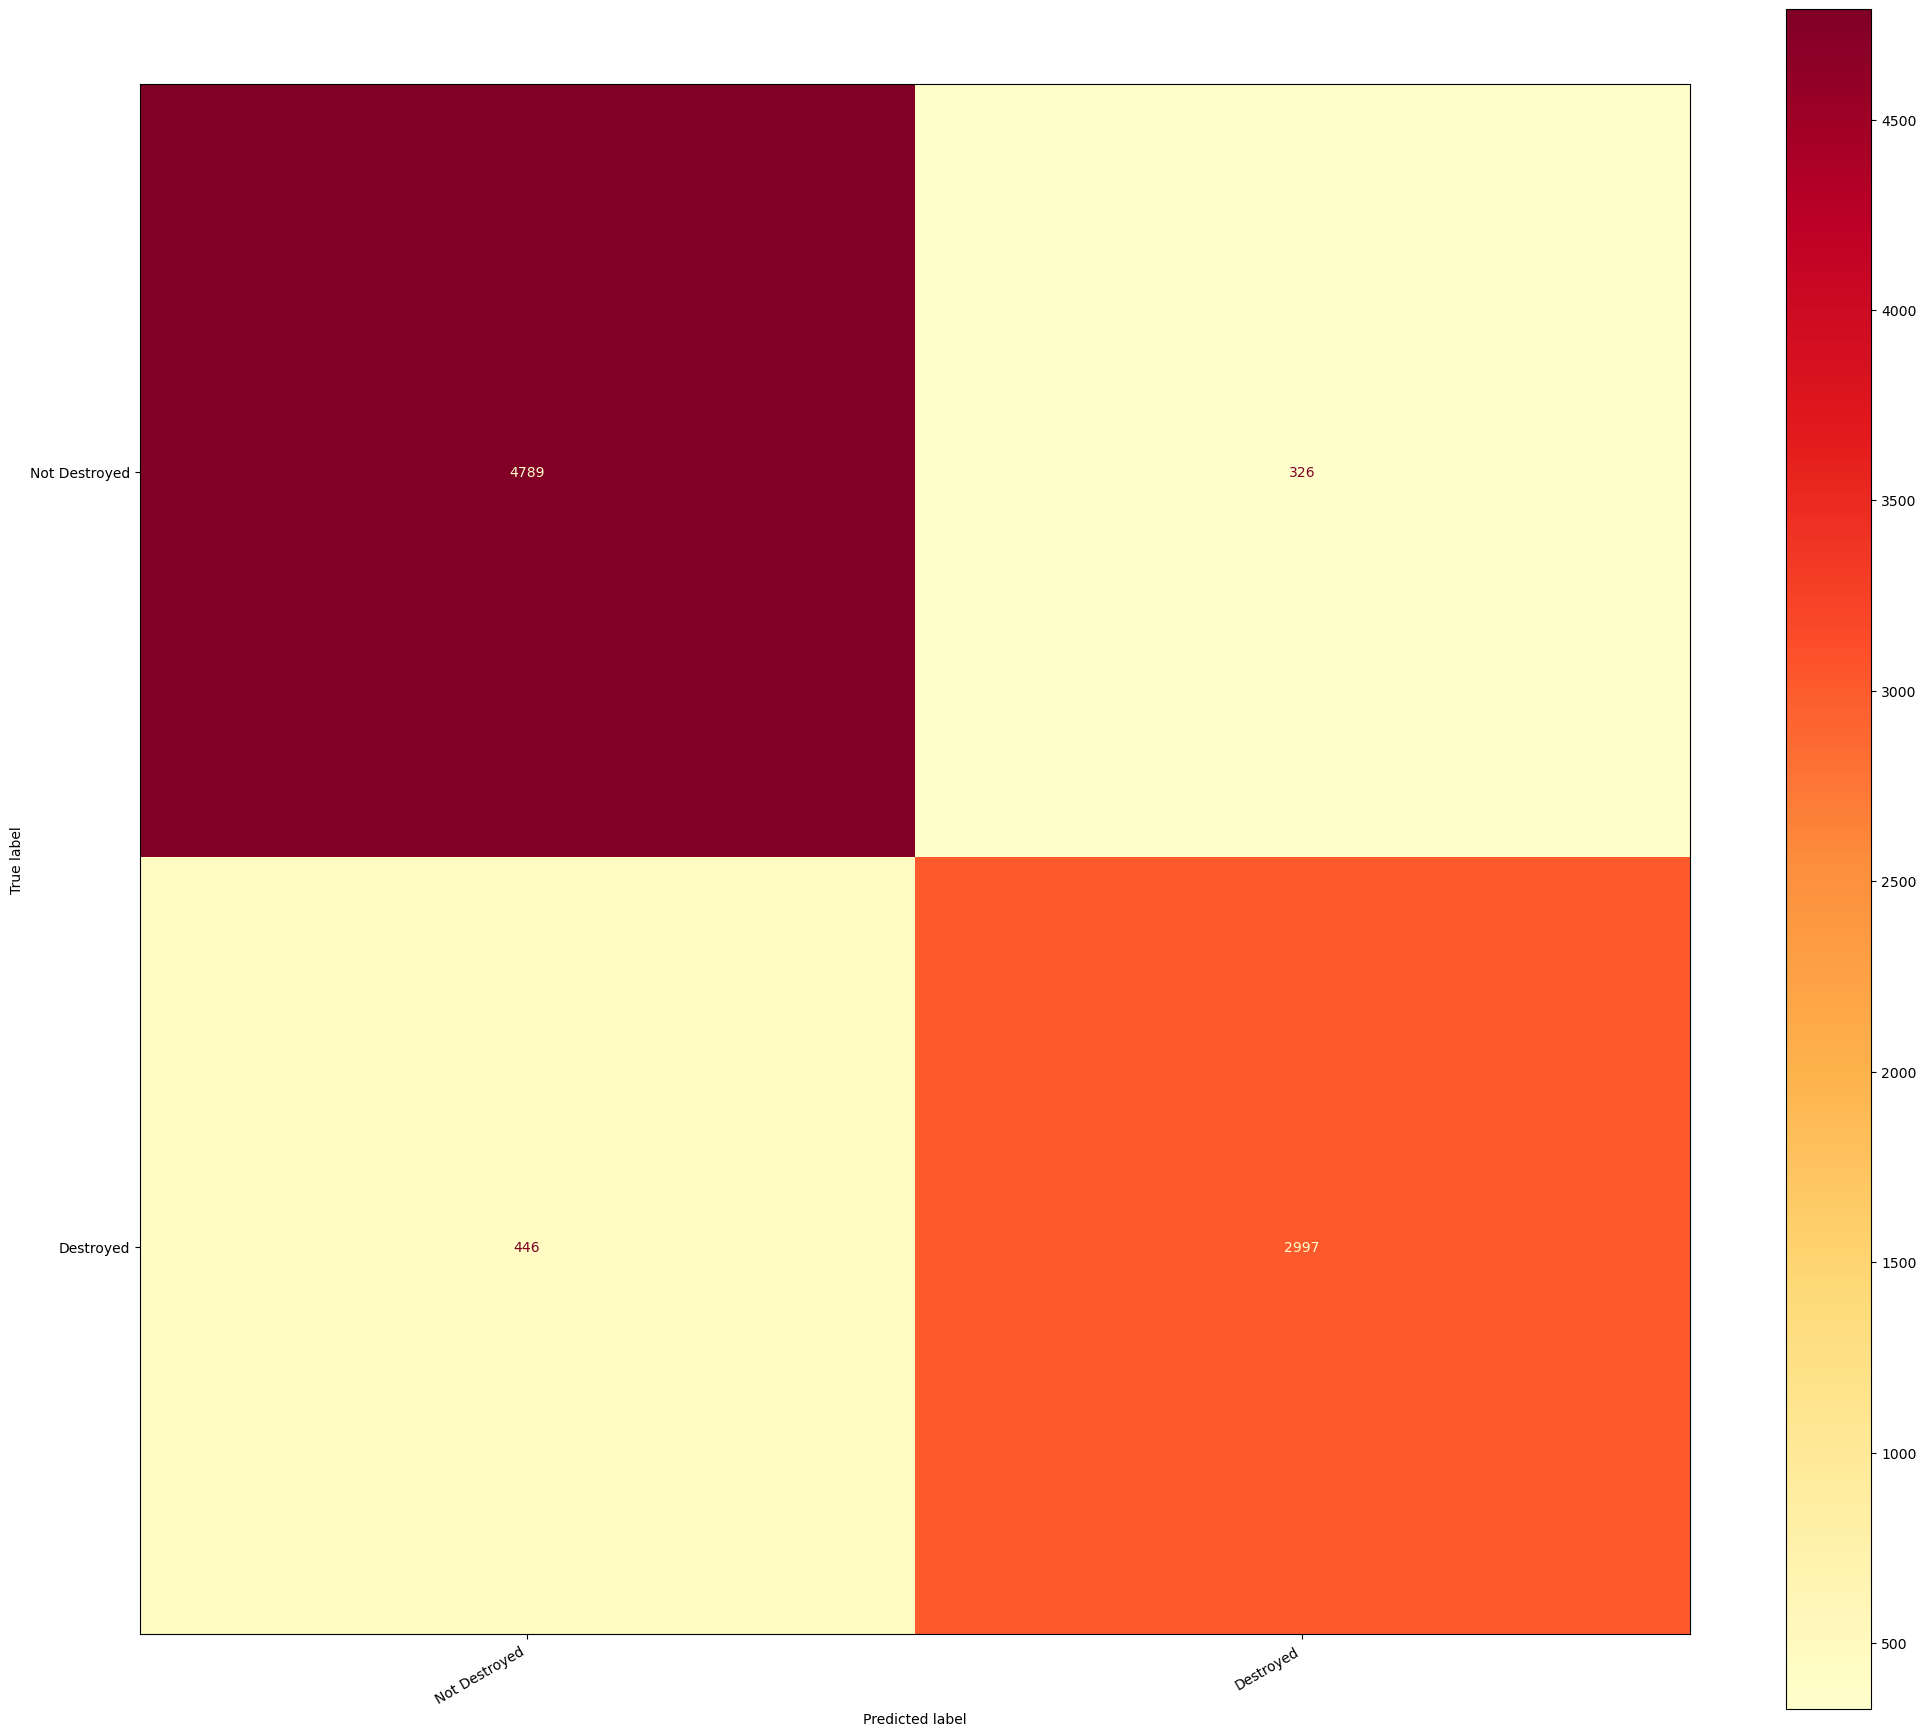

In [18]:
cm = confusion_matrix(y_test, best_gbc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.show()
